<a href="https://colab.research.google.com/github/ysgrProgramming/Yathzee/blob/main/Yahtzee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ボードゲーム「ヨット」の解析

海外ではYahtzeeと呼ばれる、5つのサイコロを使ったゲームの最大期待値手順解析を行いました。

解析の手順と結果の考察、実際にプレイした結果についてまとめました。

ここではNintendo Switch用ソフト「世界のアソビ大全」に収録されているヨットのルールを採用しています。

# 解析道具の構築

## ライブラリのインポート

使いそうなライブラリを先にインポートしておく。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 役の定義

ルールが地域差等によって一定でないので、実際の役をより一般化して定義している。

handは昇順または降順でソートされていることが期待される。

`rank_list`として、「世界のアソビ大全」収録のヨットのルールに基づいた役のリストを作成した。

In [60]:
#一般化した役関数の定義
def rank_num(hand, num):
    return hand.count(num)*num

def rank_num_of_kind(hand, num, point=None):
    count, buf = 0, -1
    for i in hand:
        if buf == i:
            count += 1
            if count == num: break
        else:
            count = 1
            buf = i
    else: return 0

    if point: return point
    else: return sum(hand)

def rank_full_house(hand, point=None):
    if hand[0] == hand[1] and hand[3] == hand[4] and hand[0] != hand[4]:
        if hand[2] == hand[0] or hand[2] == hand[4]:
            if point: return point
            else: return sum(hand)
    return 0

def rank_straight(hand, num, point=None):
    count, buf = 0, -1
    for i in hand:
        if i == buf+1:
            count += 1
            if count == num: break
        elif i == buf: continue
        else: count = 1
        buf = i
    else: return 0

    if point: return point
    else: return sum(hand)

def rank_chance(hand):
    return sum(hand)

# 役リストの作成
rank_list = []
rank_list.append(lambda hand: rank_num(hand, 1))
rank_list.append(lambda hand: rank_num(hand, 2))
rank_list.append(lambda hand: rank_num(hand, 3))
rank_list.append(lambda hand: rank_num(hand, 4))
rank_list.append(lambda hand: rank_num(hand, 5))
rank_list.append(lambda hand: rank_num(hand, 6))
rank_list.append(rank_chance)
rank_list.append(lambda hand: rank_num_of_kind(hand, 4))
rank_list.append(rank_full_house)
rank_list.append(lambda hand: rank_straight(hand, 4, 15))
rank_list.append(lambda hand: rank_straight(hand, 5, 30))
rank_list.append(lambda hand: rank_num_of_kind(hand, 5, 50))

rankname_list = ["エース(1)", "デュース(2)", "トレイ(3)", "フォー(4)", "ファイブ(5)", "シックス(6)", "チョイス", "フォーダイス", "フルハウス", "S.ストレート", "B.ストレート", "ヨット"]

sample_pat = (3, 4, 5, 6, 6)
print("出目:", sample_pat)
for func, name in zip(rank_list, rankname_list):
    print("役名:{0}, 点数:{1}".format(name, func(sample_pat)))

出目: (3, 4, 5, 6, 6)
役名:エース(1), 点数:0
役名:デュース(2), 点数:0
役名:トレイ(3), 点数:3
役名:フォー(4), 点数:4
役名:ファイブ(5), 点数:5
役名:シックス(6), 点数:12
役名:チョイス, 点数:24
役名:フォーダイス, 点数:0
役名:フルハウス, 点数:0
役名:S.ストレート, 点数:15
役名:B.ストレート, 点数:0
役名:ヨット, 点数:0


## パターンリストの作成
n個のサイコロの出目のパターンとその整数確率比を格納するリストを作成する。$6^5$通りを全探索するよりも計算量の改善が見込める。

In [63]:
from itertools import product

rank_len = len(rank_list)
bonus, bonus_point = 35, 63
data_list = np.array([[-1]*(bonus_point+1) for _ in range(1<<rank_len)], dtype=float)
data_list[-1,:] = 0

rate_list = [dict() for _ in range(5)]
for i in range(5):
    rate = 6**(4-i)
    for a in product(range(1, 7), repeat=i+1):
        key = tuple(sorted(a))
        if key in rate_list[i]:
            rate_list[i][key] += rate
        else: 
            rate_list[i][key] = rate

pat_dict = {k: i for i, k in enumerate(rate_list[-1].keys())}
pat_list = np.array([k for k in rate_list[-1].keys()])
pat_val_list = np.array([v for v in rate_list[-1].values()])

## パターンの遷移についてのリストを作成する

パターンと役の組み合わせによる点数のリスト、`rank_point_list`を作成した。

パターンとキープの組み合わせによる遷移先のパターンとその整数確率のリスト、`trans_list`を作成した。整数確率とは、確率に$6^5$をかけて表す。

In [21]:
pat_len = len(rate_list[-1])

#パターンと役の組み合わせによる点数のリスト
rank_point_list = np.zeros((pat_len, rank_len), dtype=int)
for i, k in enumerate(rate_list[-1].keys()):
    for j in range(rank_len):
        rank_point_list[i][j] = rank_list[j](k)

#choiceを含むパターンを全て生成
def list_pat(choice):
    n = len(choice)
    for key, value in rate_list[4-n].items():
        key = list(key)
        key.extend(choice)
        pat = tuple(sorted(key))
        yield pat, value

#パターンとキープの組み合わせによる遷移先のパターンとその整数確率のリスト
trans_list = [[] for _ in range(pat_len)]
weight_list = [[] for _ in range(pat_len)]
keep_list = [[] for _ in range(pat_len)]
for i, k in enumerate(rate_list[-1].keys()):
    choice_set = set()
    for j in range(1, 1<<5):
        trans = []
        weight = []
        choice = []
        for l in range(5):
            if 1<<l & j: continue
            choice.append(k[l])
        choice = tuple(choice)
        if choice in choice_set: continue
        choice_set.add(choice)
        for pat, value in list_pat(choice):
            trans.append(pat_dict[pat])
            weight.append(value)
        trans_list[i].append(np.array(trans, dtype=int))
        weight_list[i].append(np.array(weight, dtype=int))
        keep_list[i].append(choice)

In [25]:
#出目確定時の期待値
def init_val_list(bit_set, bonus_index):
    val_list = np.zeros(pat_len, dtype=float)
    available_list = []
    for i in range(rank_len):
        if bit_set & 1<<i == 0: available_list.append(i)

    for i in range(pat_len):
        for j in available_list:
            bonus_add = 0
            if j < 6: bonus_add = rank_point_list[i][j]
            if bonus_index+bonus_add >= bonus_point and bonus_index < bonus_point:
                val = rank_point_list[i,j] + bonus + data_list[bit_set+(1<<j)][-1]
            else: 
                val = rank_point_list[i,j] + data_list[bit_set+(1<<j)][min(bonus_point, bonus_index+bonus_add)]
            val_list[i] = max(val_list[i], val)
    
    return val_list

#振数残存時の期待値
def update_val_list(val_list):
    new_val_list = np.copy(val_list)
    for i in range(pat_len):
        for trans, weight in zip(trans_list[i], weight_list[i]):
            val = sum(val_list[trans]*weight) / 6**5
            new_val_list[i] = max(val, new_val_list[i])
    return new_val_list

In [36]:
def find_earnest_keep(val_list, hand):
    index = pat_dict[hand]
    route_list = [(val_list[index], hand)]
    for trans, weight, keep in zip(trans_list[index], weight_list[index], keep_list[index]):
        val = sum(val_list[trans]*weight) / 6**5
        route_list.append((val, keep))
    route_list.sort(reverse=True)
    return route_list

def find_earnest_rank(current_rank, hand, bonus_index):
    index = pat_dict[hand]
    route_list = []
    for i in range(rank_len):
        if current_rank & 1<<i: continue
        bonus_add = 0
        if i < 6: bonus_add = rank_point_list[index, i]
        if bonus_index+bonus_add >= bonus_point and bonus_index < bonus_point:
            val = rank_point_list[index, i] + bonus + data_list[current_rank+(1<<i)][-1]
        else: 
            val = rank_point_list[index, i] + data_list[current_rank+(1<<i)][min(bonus_point, bonus_index+bonus_add)]
        route_list.append((val, i, bonus_add))
    route_list.sort(reverse=True)
    return route_list

# 解析

解析道具を構築した後、解析を行った。解析には約5時間を要するので、Google Colabのランタイムの切断による作業データの消失を防ぐため、$2^8$ステップ毎に`data_list`を保存することにした。作業の再開には保存したデータを`np.load`で読み込み、ファイルに書いてある数字を`pause`に設定することでその場所から再開できる。

In [ ]:
data_list = np.load("2304.npy")
pause = 2304
for i in range(pause, -1, -1):
    bonus_limit = 0
    for j in range(6):
        if i & 1<<j == 0: bonus_limit += (j+1)*5
    
    for j in range(max(0, bonus_point-bonus_limit), bonus_point+1):
        val_list = init_val_list(i, j)
        for k in range(2):
            val_list = update_val_list(val_list)

        total = sum(val_list*pat_val_list) / 6**5
        data_list[i][j] = total

    for j in range(bonus_point-bonus_limit):
        data_list[i][j] = data_list[i][-1]

    print(bin(i)[2:])
    print(data_list[i])
    print()
    if i % (1<<8) == 0: np.save("{0}".format(i), data_list)

# プレイ

解析データを使って、実際のゲームプレイ例を生成するサンプルを作成した。解析後のデータはGithub上に保存してある。

In [34]:
data_list = np.load("yahtzee_data_list.npy")

In [62]:
current_rank = 0
total = 0
bonus_index = 0

def make_hand(keep):
    hand = np.random.randint(1, 7, 5)
    for k in range(len(keep)):
        hand[k] = keep[k]
    hand = tuple(sorted(hand))
    print(hand)
    return hand

for i in range(rank_len):
    #一手目
    #hand = tuple(sorted(map(int, input().split())))
    hand = make_hand([])
    val_list = init_val_list(current_rank, bonus_index)
    val_list = update_val_list(val_list)
    route_list = find_earnest_keep(val_list, hand)
    for i in range(min(3, len(route_list))):
        print("第{0}候補 期待値:{1}, 選択:{2}".format(i+1, route_list[i][0]+total, route_list[i][1]))

    #二手目
    #hand = tuple(sorted(map(int, input().split())))
    hand = make_hand(route_list[0][1])
    index = pat_dict[hand]
    val_list = init_val_list(current_rank, bonus_index)
    route_list = find_earnest_keep(val_list, hand)
    for i in range(min(3, len(route_list))):
        print("第{0}候補 期待値:{1}, 選択:{2}".format(i+1, route_list[i][0]+total, route_list[i][1]))

    #三手目
    #hand = tuple(sorted(map(int, input().split())))
    hand = make_hand(route_list[0][1])
    index = pat_dict[hand]
    route_list = find_earnest_rank(current_rank, hand, bonus_index)
    for i in range(min(3, len(route_list))):
        print("第{0}候補 期待値:{1}, 選択:{2}".format(i+1, route_list[i][0]+total, rankname_list[route_list[i][1]]))

    choiced_rank, bonus_add = route_list[0][1:]
    current_rank += 1<<choiced_rank
    total += rank_point_list[index, choiced_rank]
    if bonus_index+bonus_add >= bonus_point and bonus_index < bonus_point: total += bonus
    bonus_index = min(bonus_point, bonus_index+bonus_add)

    print("現在の得点:{0}, ボーナスまで:{1}, 役状況:{2}".format(total, bonus_point-bonus_index, bin(current_rank)[2:].zfill(rank_len)))
    print()

(2, 2, 4, 5, 6)
第1候補 期待値:188.29764338823892, 選択:(2, 2)
第2候補 期待値:188.20008761052884, 選択:(5,)
第3候補 期待値:188.17446889387992, 選択:(6,)
(2, 2, 2, 3, 5)
第1候補 期待値:190.05735701545254, 選択:(2, 2, 2)
第2候補 期待値:188.34852337442766, 選択:(2, 2, 2, 5)
第3候補 期待値:188.23281800281575, 選択:(2, 2, 2, 3)
(1, 2, 2, 2, 6)
第1候補 期待値:187.22528381389165, 選択:デュース(2)
第2候補 期待値:179.16698311647707, 選択:エース(1)
第3候補 期待値:175.97752671114287, 選択:フォーダイス
現在の得点:6, ボーナスまで:57, 役状況:000000000010

(2, 5, 6, 6, 6)
第1候補 期待値:196.62958554613058, 選択:(6, 6, 6)
第2候補 期待値:194.7149873522679, 選択:(5, 6, 6, 6)
第3候補 期待値:194.03074511361396, 選択:(2, 6, 6, 6)
(2, 2, 6, 6, 6)
第1候補 期待値:191.6468376376686, 選択:(6, 6, 6)
第2候補 期待値:189.7522910695923, 選択:(2, 2, 6, 6, 6)
第3候補 期待値:188.45281533320085, 選択:(2, 6, 6, 6)
(4, 6, 6, 6, 6)
第1候補 期待値:202.80534829404795, 選択:シックス(6)
第2候補 期待値:199.592026352583, 選択:フォーダイス
第3候補 期待値:182.07637624666305, 選択:チョイス
現在の得点:30, ボーナスまで:33, 役状況:000000100010

(3, 3, 5, 5, 6)
第1候補 期待値:202.79076687753326, 選択:(5, 5)
第2候補 期待値:202.07340987801223, 選択

# 解析結果の妥当性の評価

In [58]:
n = 100
point_list = np.zeros(n)
for i in range(n):
    current_rank, total, bonus_index = 0, 0, 0
    for j in range(rank_len):
        hand = tuple(sorted(np.random.randint(1, 7, 5)))
        val_list1 = init_val_list(current_rank, bonus_index)
        val_list2 = update_val_list(val_list1)
        route_list = find_earnest_keep(val_list2, hand)
        keep = route_list[0][1]

        hand = np.random.randint(1, 7, 5)
        for k in range(len(keep)):
            hand[k] = keep[k]
        hand = tuple(sorted(hand))
        route_list = find_earnest_keep(val_list1, hand)
        keep = route_list[0][1]

        hand = np.random.randint(1, 7, 5)
        for k in range(len(keep)):
            hand[k] = keep[k]
        hand = tuple(sorted(hand))
        index = pat_dict[hand]
        route_list = find_earnest_rank(current_rank, hand, bonus_index)

        rank, bonus_add = route_list[0][1:]
        current_rank += 1<<rank
        total += rank_point_list[index, rank]
        if bonus_index+bonus_add >= bonus_point and bonus_index < bonus_point: total += bonus
        bonus_index = min(bonus_point, bonus_index+bonus_add)
    point_list[i] = total
print(point_list)

[240. 170. 116. 240. 119. 135. 146. 189. 241. 202. 260. 167. 183. 186.
 180. 204. 215. 169. 264. 135. 168. 139. 189. 198. 166. 214. 223. 238.
 203. 194. 186. 190. 193. 177. 249. 140. 187. 126. 198. 250. 132. 173.
 114. 216. 215. 174. 192. 168. 196. 185. 242. 211. 181. 199. 186. 146.
 214. 199. 182. 241. 215. 190. 213. 152. 205. 262. 201. 195. 262. 141.
 166. 213. 237. 210. 271. 242. 172. 162. 158. 197. 223. 199. 171. 160.
 150. 152. 228. 138. 264. 179. 161. 189. 126. 193. 142. 213. 226. 216.
 241. 182.]


min:114.0, max:271.0
25%:168.0, 50%:192.0, 75%:215.0
期待値(実測値): 191.72
期待値(理論値): 191.76087975216527


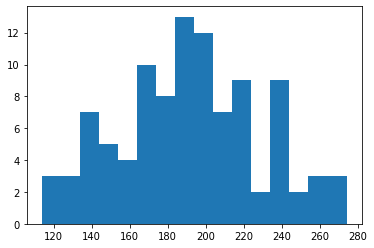

In [59]:
interval = 10
x = np.arange(min(point_list), max(point_list), interval)
count_list = []
for i in x:
    count_list.append(np.count_nonzero((i <= point_list) & (point_list < i+interval)))
plt.bar(x+interval/2, count_list, width=interval)
point_list.sort()
ave = sum(point_list)/len(point_list)

print("min:{0}, max:{1}".format(point_list[0], point_list[-1]))
print("25%:{0}, 50%:{1}, 75%:{2}".format(point_list[n//4], point_list[n//2], point_list[n*3//4]))
print("期待値(実測値):", ave)
print("期待値(理論値):", data_list[0][0])